## Задача
- [x] Сгенерировать 10 000 пользователей с помощью UUID4;
- [x] С вероятностью в 10% назначить пользователям факт совершения некоторого действия;
- [x] Распределить пользователей 10 000 раз по контрольной и тестовой группе. Для каждой итерации новая соль;
- [x] Для каждой итерации определить значимость отличия конверсии в исходное действие с p_value = 0.05;
- [x] Построить распределение полученных 10 000 p_value на графике. Какое распределение получилось? 
- [x] Проверить соответствие полученного распределения с равномерным с помощью теста Колмогорова-Смирнова;
- [x] Сделать выводы;
 

## Импорты и функции

In [1]:
import uuid
import hashlib
import warnings
import sqlite3
import numpy as np
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest
from scipy import stats
from tqdm.auto import tqdm

In [2]:
warnings.filterwarnings('ignore')
connect = sqlite3.connect('db.sqlite')

In [3]:
def generate_users_with_actions(num_users: int = None, action_probability: int = None) -> pd.DataFrame:
    """Генерирует популяцию с заданным количеством пользователей и заданной вероятностью конверсии в целевое действие"""

    np.random.seed(42)

    users = [str(uuid.uuid4()) for _ in range(num_users)]
    actions = np.random.binomial(1, action_probability, size=num_users)
    data = {}
    for key, val in zip(users, actions):
        data[key] = val

    result = pd.DataFrame(data=list(data.items()), columns=['user', 'action'])

    return result

In [4]:
def split_users(user_id, salt: str) -> int:
    """Распределяет пользователей по 2м группам АБ-теста"""

    hash_object = hashlib.md5((user_id + salt).encode())
    hash_hex = hash_object.hexdigest()
    hash_int = int(hash_hex, 16)

    group = ''
    if hash_int % 100 <= 50:
        group = 'control'
    else:
        group = 'test'

    return group

In [5]:
def create_and_estimate_ab(data: pd.DataFrame, salt: int, alpha: float) -> pd.DataFrame:
    """Проводит АБ и возвращает результаты"""

    data = data.copy()
    data['group'] = data.apply(lambda row: split_users(user_id=row['user'], salt=str(salt)), axis=1)
    data = data.pivot_table(index=['group'], columns='action', values='user', aggfunc='count',
                            margins=True, margins_name='total')

    separation = {
        'control_successes': data.loc['control', 1],
        'control_total': int(data.loc['control', 'total']),
        'control_cr': data.loc['control', 1] / data.loc['control', 'total'],
        'test_successes': data.loc['test', 1],
        'test_total': data.loc['test', 'total'],
        'test_cr': data.loc['test', 1] / data.loc['test', 'total'],
    }

    z_score, p_value = proportions_ztest(
        count=[separation['control_successes'], separation['test_successes']],
        nobs=[separation['control_total'], separation['test_total']],
        alternative='two-sided')

    if p_value < alpha:
        h_0 = 'reject'
    else:
        h_0 = 'not_reject'

    results_ab = {
        'h_0': h_0,
        'p_value': p_value,
        'z_score': z_score,
        'control_cr': separation['control_cr'],
        'test_cr': separation['test_cr'],
        'control_total': separation['control_total'],
        'control_successes': separation['control_successes'],
        'test_total': separation['test_total'],
        'test_successes': separation['test_successes']
    }

    df_row = pd.DataFrame(results_ab, index=[0])

    del data

    return df_row

In [6]:
def get_data(type: str, save_to_db: bool, num_users, num_experiments: int, action_probability, alpha: float) -> pd.DataFrame:
    """    
    :param type: generate or load
    """

    df = pd.DataFrame(
        columns=['h_0', 'p_value', 'z_score', 'control_cr', 'test_cr', 'control_total',
                 'control_successes', 'test_total', 'test_successes'])

    population = generate_users_with_actions(num_users=num_users, action_probability=action_probability)

    if type == 'generate':
        for i in tqdm(range(num_experiments)):
            exp = create_and_estimate_ab(data=population, salt=i, alpha=alpha)
            df = pd.concat([df, exp], ignore_index=True)

        # Мини-фикс на тип данных, чтобы в итоговом DF инты были интами 
        df[['control_total', 'control_successes', 'test_total', 'test_successes']] = df[
            ['control_total', 'control_successes', 'test_total', 'test_successes']].astype(int)
    
        if save_to_db:
            df.to_sql(name='intensive_syntetic_ab_test', con=connect, if_exists='replace')

    elif type == 'load':
        df = pd.read_sql('SELECT * FROM intensive_syntetic_ab_test', con=connect)

    return df

## Анализируем данные

In [10]:
df = get_data(type='load', save_to_db=False, num_users=10_000, num_experiments=10_000, action_probability=0.1, alpha=0.50)

In [11]:
df.sample(5)

,index,h_0,p_value,z_score,control_cr,test_cr,control_total,control_successes,test_total,test_successes
447,447,not_reject,0.709107,-0.373055,0.095012,0.097211,5052,480,4948,481
3381,3381,not_reject,0.472248,-0.718826,0.094047,0.098286,5157,485,4843,476
1478,1478,not_reject,0.764341,-0.299785,0.095238,0.097006,5124,488,4876,473
2149,2149,not_reject,0.521836,-0.640518,0.094247,0.098023,5093,480,4907,481
4719,4719,not_reject,0.468240,-0.725346,0.094007,0.098284,5106,480,4894,481


In [13]:
# Прежде чем переходить к анализу распределения p_value посмотрим на соотношение reject/not_reject H0.
# Так как в нашей популяции CR~10%, то кажется, что при семплировании мы всегда должны получать выборки (control/test)
# с аналогичной конверсией, а значит H0 всегда должна быть верной (разницы между группами не будет).
# Но цифры покажут, что это не так.
df['h_0'].value_counts(normalize=True)

h_0
not_reject    0.951
reject        0.049
Name: proportion, dtype: float64

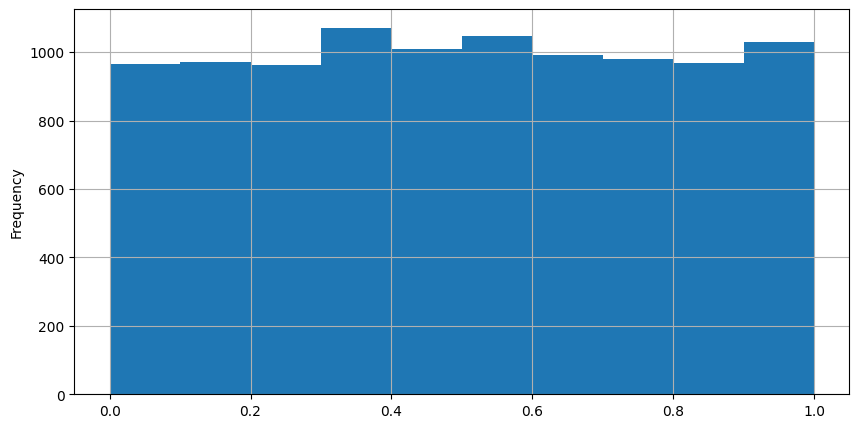

In [14]:
# Смотрим распределение получившихся p_value. Выглядит как что-то очень похожее на равномерное распределение. 
df['p_value'].plot(kind='hist', figsize=(10, 5), grid=True);

In [15]:
# Проверим равномерность распределения ч помощью теста Колмогорова-Смирнова.
p_value = stats.kstest(df['p_value'], 'uniform')[1]
if p_value < 0.05:
    print(f'H0 reject, p_value: {p_value}')
else:
    print(f'H0 not reject. p_value: {p_value}')

H0 not reject. p_value: 0.16505858146931573


## Выводы

1. У нас есть синтетически сгенерированная популяция, в которой конверсия в целевое действие ~10%. Если мы честно и случайно разделяем эту популяцию на группы для АБ, то мы ожидаем, что каждый раз это будут одинаковые выборки (не будет разницы в конверсиях). Но данные говорят обратное, у нас 5% случаев, в которых $H_{0}$ была отвергнута (test и control отличались). И это не очень интуитивно, но показывает как велика доля случайности, когда в реальном мире мы проводим __один__ АБ, а не 10000 вариантов одного АБ.  

2. Равномерное распределение p-value может говорить о том, что 
    - нулевая гипотеза (отсутствие эффекта в АБ) не была отвергнута чаще, чем ожидалось по случайности (alpha). То есть наши синтетические тесты не имеют систематического смещения и работают корректно при отсутствии реальных различий между группами.
    - в большинстве итераций не было значимых различий между control и test.

3. ???
